In [ ]:
#!pip install cmapPy
#!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00


In [78]:
import pandas as pd
import numpy as np
import gzip
import re
from cmapPy.pandasGEXpress.parse import parse
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from sklearn.metrics.pairwise import cosine_similarity


Download expression and necessary metadata

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_inst_info_2017-03-06.txt.gz

--2024-06-15 00:38:35--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_inst_info_2017-03-06.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4783200 (4.6M) [application/x-gzip]
Saving to: ‘GSE70138_Broad_LINCS_inst_info_2017-03-06.txt.gz’

GSE70138_Broad_LINC 100%[===================>]   4.56M  2.87MB/s    in 1.6s    

2024-06-15 00:38:37 (2.87 MB/s) - ‘GSE70138_Broad_LINCS_inst_info_2017-03-06.txt.gz’ saved [4783200/4783200]



In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_Level2_GEX_n345976x978_2017-03-06.gctx.gz
!gunzip GSE70138_Broad_LINCS_Level2_GEX_n345976x978_2017-03-06.gctx.gz

--2024-06-15 00:38:37--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70138/suppl/GSE70138_Broad_LINCS_Level2_GEX_n345976x978_2017-03-06.gctx.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 668884165 (638M) [application/x-gzip]
Saving to: ‘GSE70138_Broad_LINCS_Level2_GEX_n345976x978_2017-03-06.gctx.gz’

GSE70138_Broad_LINC 100%[===================>] 637.90M  14.6MB/s    in 46s     

2024-06-15 00:39:24 (13.9 MB/s) - ‘GSE70138_Broad_LINCS_Level2_GEX_n345976x978_2017-03-06.gctx.gz’ saved [668884165/668884165]



### Import the metadata

Please note the columns of particular interest
- inst_id: ID col, used to join the metadata with the data
- cell_id: cell line
- det_plate: can be used as the experimental batch, i.e. all the wells with the same det_plate were ran together

And especially columns relating to the perturbation:
- pert_iname: human readable name of perturbant
- pert_dose: concentration of perturbant
- pert_time: time between perturbation and measurement CHECK!
- pert_type: whether this perturbant is a negative control or treatment, and whether it's a small compound or genetic perturbation

In [ ]:
inst_info = pd.read_csv("GSE70138_Broad_LINCS_inst_info_2017-03-06.txt.gz", sep='\t')
inst_info.head()

,inst_id,cell_id,det_plate,det_well,pert_mfc_id,pert_dose,pert_dose_unit,pert_id,pert_iname,pert_type,pert_time,pert_time_unit
0,LJP005_A375_24H_X1_B19:A03,A375,LJP005_A375_24H_X1_B19,A03,DMSO,-666.0,-666,DMSO,DMSO,ctl_vehicle,24.0,h
1,LPROT001_A375_6H_X1_B20:B03,A375,LPROT001_A375_6H_X1_B20,B03,DMSO,-666.0,-666,DMSO,DMSO,ctl_vehicle,6.0,h
2,LPROT001_A375_6H_X1_B20:B05,A375,LPROT001_A375_6H_X1_B20,B05,DMSO,-666.0,-666,DMSO,DMSO,ctl_vehicle,6.0,h
3,LPROT002_A375_6H_X1_B22:B03,A375,LPROT002_A375_6H_X1_B22,B03,DMSO,-666.0,-666,DMSO,DMSO,ctl_vehicle,6.0,h
4,LPROT002_A375_6H_X1_B22:B05,A375,LPROT002_A375_6H_X1_B22,B05,DMSO,-666.0,-666,DMSO,DMSO,ctl_vehicle,6.0,h


## Import the expression data

Here we will work with lincs L1000 data, level 2.

> Note that level 2 is _not_ the standardly recommend starting point as it often rather used with normalization, processing (such as imputation), batch correction (level 4), and aggregation (level 5). However we utilize this because
- it surfaces many of the realistic challenges of working with _any_ expression data
- it is much smaller, which is useful for a quick lab


This data contains a matrix with
"landmark genes" in the rows
and "samples" or "wells" in the columns.
The values are the the measured abundance of
the mRNAs derived from the given
landmark gene in a given sample.

Landmark genes are a subset of ~1000 genes
that are sufficient to predict much of the
variation in all 20k genes. Only these 1000
are measured in the l1000 data for cost reasons. This contrasts with _sequencing_ based transcriptomics, which is not selective for a subset of target genes.

Find more information [in the paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5990023/).

In [ ]:
gene_abundance = parse("GSE70138_Broad_LINCS_Level2_GEX_n345976x978_2017-03-06.gctx",
                       convert_neg_666=True).data_df

In [ ]:
gene_abundance.head()

cid,REP.A001_A375_24H_X1_B22:A03,REP.A001_A375_24H_X1_B22:A04,REP.A001_A375_24H_X1_B22:A05,REP.A001_A375_24H_X1_B22:A06,REP.A001_A375_24H_X1_B22:A07,REP.A001_A375_24H_X1_B22:A08,REP.A001_A375_24H_X1_B22:A09,REP.A001_A375_24H_X1_B22:A10,REP.A001_A375_24H_X1_B22:A11,REP.A001_A375_24H_X1_B22:A12,...,XPR002_YAPC.311_96H_X3_B22:P15,XPR002_YAPC.311_96H_X3_B22:P16,XPR002_YAPC.311_96H_X3_B22:P17,XPR002_YAPC.311_96H_X3_B22:P18,XPR002_YAPC.311_96H_X3_B22:P19,XPR002_YAPC.311_96H_X3_B22:P20,XPR002_YAPC.311_96H_X3_B22:P21,XPR002_YAPC.311_96H_X3_B22:P22,XPR002_YAPC.311_96H_X3_B22:P23,XPR002_YAPC.311_96H_X3_B22:P24
rid,,,,,,,,,,,,,,,,,,,,,
5720,1431.0,938.0,1069.0,1095.0,1075.0,1145.0,887.0,1058.0,1310.0,1183.0,...,5390.0,5057.0,5041.0,4370.0,4274.0,5009.0,5290.0,4760.0,4900.0,4510.0
55847,1270.0,935.0,1036.0,966.0,1147.0,1056.0,899.0,1105.0,1329.0,1262.0,...,1336.0,1383.0,1525.0,1157.0,1093.0,1412.0,1599.0,1255.0,1593.0,1457.0
7416,2831.0,2266.0,2593.0,2349.0,2441.0,2488.0,2264.0,2540.0,2531.0,2590.0,...,3401.0,3470.0,3704.0,2847.0,3032.0,3736.0,3552.0,3163.0,3320.0,3303.0
10174,164.0,118.0,154.0,142.0,226.0,151.0,193.0,162.0,213.0,164.0,...,382.0,442.0,227.0,261.0,204.0,240.0,282.0,276.0,478.0,199.0
25803,214.0,183.0,196.0,195.0,168.0,204.0,133.0,220.0,268.0,225.0,...,243.0,248.0,407.0,397.0,292.0,415.0,462.0,384.0,305.0,331.0


#### Data distribution
Transcriptomics data is generally not normally distributed, while many of the losses or metrics we use in ML work better with normally distributed data. The l1000 is not count data, but we can still see it's not normal

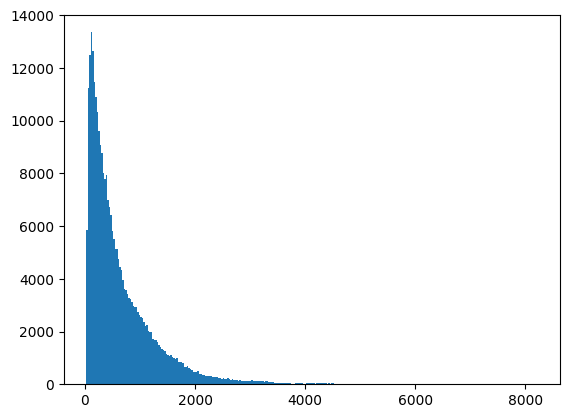

In [ ]:
# note the long tail
_ = plt.hist(gene_abundance.iloc[:,:300].values.flatten(), bins=300)

> Note: the following normalization and scaling differs from the recomendation for l1000 for the sake of simplicity and showing general steps which apply to many transcriptomics types. For l1000 outside of this lab, you can simply take the level 4 or 5 pre-normalized data, or take a look at the author's [write up of "Level 3 - Normalization (NORM)"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5990023/#S40title). For sequencing data, a few good options are to either use raw counts and adjust loss & metrics for a negative binomial distribution _or_ one could perform variance stabilizing transformation with e.g. [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html).

In [ ]:
# log transform
gene_normalized = np.log(gene_abundance.values) + 0.001
# scale each sample to same total abundance
gene_normalized = gene_normalized / np.mean(gene_normalized, axis=0) * np.mean(gene_normalized)
# center at 0
gene_normalized = gene_normalized - np.mean(gene_normalized)


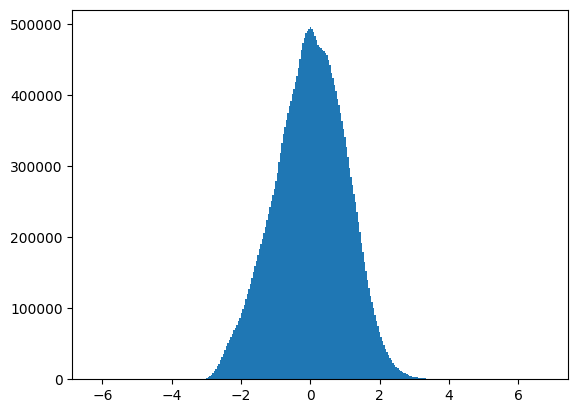

In [ ]:
_ = plt.hist(gene_normalized[:,:30000].flatten(), bins=300)

While the transformations have not resulted in a perfect normal distribution, it is bell shaped and does not have extreme outliers. We'll consider this good enough to work with.

Now let's look at subgroups and structures in the data with a UMAP.

In [ ]:
reducer = umap.UMAP()


In [ ]:
# visualization tends to be clearer (and faster)
# work better when we don't take the _full_ perturbation data
N = 10000
embedding = reducer.fit_transform(gene_normalized[:,:N].T)
embedding.shape

(10000, 2)

In [ ]:
# rearrange and join with metadata for seaborn
dat = pd.DataFrame(embedding)
dat["inst_id"] = gene_abundance.columns[:N]
dat = dat.merge(inst_info, on='inst_id')

In [ ]:
dat.head()

,0,1,inst_id,cell_id,det_plate,det_well,pert_mfc_id,pert_dose,pert_dose_unit,pert_id,pert_iname,pert_type,pert_time,pert_time_unit
0,5.588719,-1.767206,REP.A001_A375_24H_X1_B22:A03,A375,REP.A001_A375_24H_X1_B22,A03,-666,-666.0,-666,DMSO,DMSO,ctl_vehicle,24.0,h
1,5.976889,-2.457912,REP.A001_A375_24H_X1_B22:A04,A375,REP.A001_A375_24H_X1_B22,A04,-666,-666.0,-666,DMSO,DMSO,ctl_vehicle,24.0,h
2,5.730121,-1.883573,REP.A001_A375_24H_X1_B22:A05,A375,REP.A001_A375_24H_X1_B22,A05,-666,-666.0,-666,DMSO,DMSO,ctl_vehicle,24.0,h
3,5.677215,-1.912449,REP.A001_A375_24H_X1_B22:A06,A375,REP.A001_A375_24H_X1_B22,A06,-666,-666.0,-666,DMSO,DMSO,ctl_vehicle,24.0,h
4,5.842314,-2.561303,REP.A001_A375_24H_X1_B22:A07,A375,REP.A001_A375_24H_X1_B22,A07,BRD-K25114078-003-08-1,10.0,um,BRD-K25114078,aminoguanidine,trt_cp,24.0,h


#### Visualize normalized, but unaligned

First we see that cell type, unsurprisingly has a dominant effect

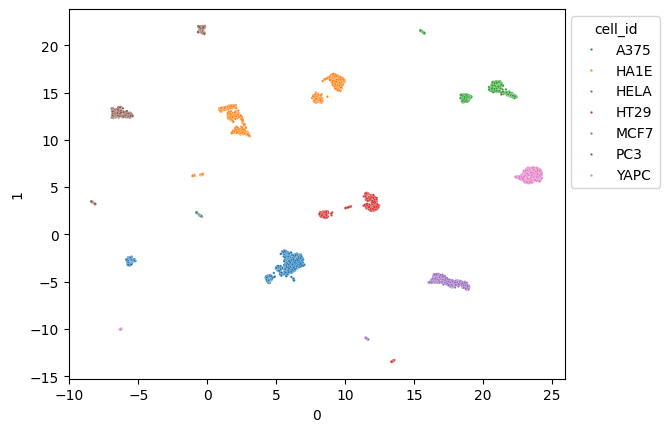

In [ ]:
ax = sns.scatterplot(dat, x=0, y=1, hue="cell_id", s=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

And within each cell type, the batch (or plate) has a large effect

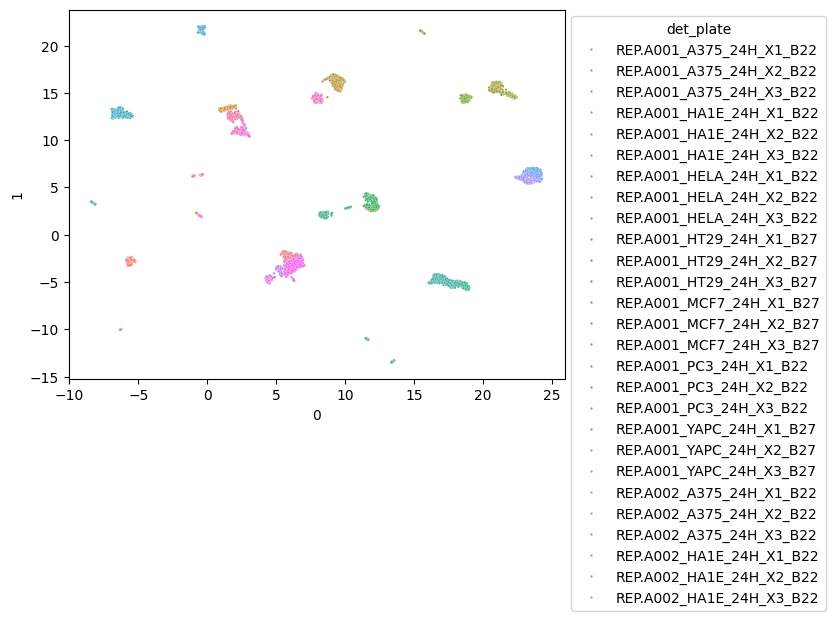

In [ ]:
ax = sns.scatterplot(dat, x=0, y=1, hue="det_plate", s=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Good to know, we'll come back to the batch effect after embedding the data

### Embedding
While the field of transcriptomics foundation models is under
rapid development, e.g. ([scGPT](https://www.nature.com/articles/s41592-024-02201-0), [scFoundation](https://www.biorxiv.org/content/10.1101/2023.05.29.542705v3), [Geneformer](https://www.nature.com/articles/s41586-023-06139-9), [Universal Cell Embeddings](https://www.biorxiv.org/content/10.1101/2023.11.28.568918v1)) the are generally sequencing specific and few are independently benchmarked to date. From the benchmarks that
have been done, it is clear that [scVI](https://www.nature.com/articles/s41592-018-0229-2), a variational autoencoder, remains a
strong baseline. None of the above actually are designed for L1000 data,
so we'll take a vanilla variational autoencoder for simplicity.

#### Data loaders

In [ ]:
# simple tabular data loader
class L1000Dataset(Dataset):
    def __init__(self, data):
        self.X = data

    def __len__(self):
        return len(self.X.T)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.X[:,idx], )
        return sample

In [ ]:
joint_dataset = L1000Dataset(gene_normalized)
total_len = len(joint_dataset)
len_train = int(total_len * .9)
len_val = total_len - len_train

> Note. In this lab we are not concerned with _generalization_.
We're simply using the embedding to reduce noise, and measuring
similarity (within set). Most ML projects with transcriptomics
data _will_ be concerned with generalization and should consider
a split that reserves whole experimental batches
(such as 'gem wells' or 'plates')
of data for the test set.

In [ ]:
training_dataset, validation_dataset = random_split(joint_dataset, lengths=[len_train, len_val])

In [ ]:
batch_size = 512
training_dataloader = DataLoader(training_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=0)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
        super(VAE, self).__init__()
        self.fc_1 = nn.Linear(x_dim, h_dim)
        self.fc_2a = nn.Linear(h_dim, z_dim)
        self.fc_2b = nn.Linear(h_dim, z_dim)
        self.fc_3 = nn.Linear(z_dim, h_dim)
        self.fc_4 = nn.Linear(h_dim, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc_1(x))
        return self.fc_2a(h), self.fc_2b(h) # mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu # z sample

    def decoder(self, z):
        h = F.relu(self.fc_3(z))
        return self.fc_4(h)

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 978))
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


vae = VAE(x_dim=978, h_dim=512, z_dim=256)
vae.to(device)

VAE(
  (fc_1): Linear(in_features=978, out_features=512, bias=True)
  (fc_2a): Linear(in_features=512, out_features=256, bias=True)
  (fc_2b): Linear(in_features=512, out_features=256, bias=True)
  (fc_3): Linear(in_features=256, out_features=512, bias=True)
  (fc_4): Linear(in_features=512, out_features=978, bias=True)
)

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    mse = F.mse_loss(recon_x, x.view(-1, 978))
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

    return mse + kld_loss * 0.0002

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, ) in enumerate(training_dataloader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(training_dataloader.dataset),
                100. * batch_idx / len(training_dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(training_dataloader.dataset)))


In [ ]:
def val():
    vae.eval()
    val_loss= 0
    with torch.no_grad():
        for (data,) in validation_dataloader:
            data = data.to(device)
            recon, mu, log_var = vae(data)

            # sum up batch loss
            val_loss += loss_function(recon, data, mu, log_var).item()

    val_loss /= len(validation_dataloader.dataset)
    print('====> Val set loss: {:.4f}'.format(val_loss))

In [ ]:
# this will take several minutes, a great time
# to read or catch up on the theory
for epoch in range(1, 6):
    train(epoch)
    val()

Train Epoch: 1 [0/311378 (0%)]	Loss: 0.000364
Train Epoch: 1 [51200/311378 (16%)]	Loss: 0.000349
Train Epoch: 1 [102400/311378 (33%)]	Loss: 0.000343
Train Epoch: 1 [153600/311378 (49%)]	Loss: 0.000323
Train Epoch: 1 [204800/311378 (66%)]	Loss: 0.000326
Train Epoch: 1 [256000/311378 (82%)]	Loss: 0.000308
Train Epoch: 1 [307200/311378 (99%)]	Loss: 0.000298
====> Epoch: 1 Average loss: 0.0003
====> Test set loss: 0.0003
Train Epoch: 2 [0/311378 (0%)]	Loss: 0.000303
Train Epoch: 2 [51200/311378 (16%)]	Loss: 0.000303
Train Epoch: 2 [102400/311378 (33%)]	Loss: 0.000301
Train Epoch: 2 [153600/311378 (49%)]	Loss: 0.000292
Train Epoch: 2 [204800/311378 (66%)]	Loss: 0.000281
Train Epoch: 2 [256000/311378 (82%)]	Loss: 0.000274
Train Epoch: 2 [307200/311378 (99%)]	Loss: 0.000282
====> Epoch: 2 Average loss: 0.0003
====> Test set loss: 0.0003
Train Epoch: 3 [0/311378 (0%)]	Loss: 0.000283
Train Epoch: 3 [51200/311378 (16%)]	Loss: 0.000297
Train Epoch: 3 [102400/311378 (33%)]	Loss: 0.000272
Train Epo

Check if output distribution is reasonable

In [ ]:
for (data, ) in validation_dataloader:
    break

In [ ]:
with torch.no_grad():
    res = vae(data.to(device))

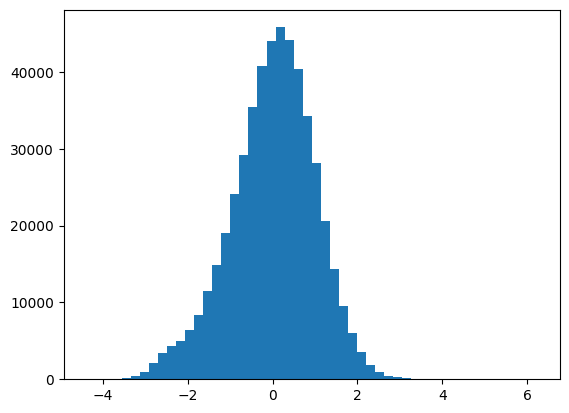

In [ ]:
# do we get a bell curve / match to ori dist?
_ = plt.hist(res[0].cpu().numpy().flatten(), bins=50)

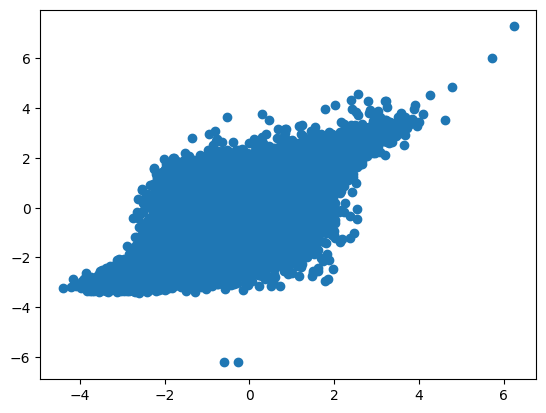

In [ ]:
# compared to exact input?
plt.scatter(res[0].cpu().numpy().flatten(),
           data.cpu().numpy().flatten())

In a performance oriented project we would perform hyperparameter tuning
using downstream metrics to select the best model. But for now,
we'll continue with this one and embed all the data.



In [ ]:
out = []
# all the data, unshuffled
joint_dataloader = DataLoader(joint_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=0)
for (data, ) in joint_dataloader:
    with torch.no_grad():
        out.append(vae(data.to(device))[1].cpu().numpy())  # 1 is the embedding, AKA mu
vae_embedding = np.concatenate(out)

### Batch correction
Even high throughput biological assays have much smaller capacity than the number of samples we wish to measure in drug discovery. Thus, the data is gathered in 'batches', for instance, everything that fits on a 384 well plate at the same time. These batches necessarily share some technical (e.g. sequencing depth) and biological (e.g. exact cell age, response to time of day) co-variation that is often greater than the effect of some individual perturbants.

How best to make downstream modelling tasks robust to the batches
in which experimental data was
collected or even integrate data from disparate studies is an evolving field
(e.g. [Harmony](https://www.nature.com/articles/s41592-019-0619-0),
[TVN](https://www.biorxiv.org/content/10.1101/161422v1.abstract),
[sysVI](https://www.biorxiv.org/content/10.1101/2023.11.03.565463v2),
[InfoCORE](https://arxiv.org/abs/2312.00718) to name only a few).
Here, we simply center each batch on the control mean and scale it by the
control standard deviation.

In [66]:
# first, helper functions
def find_controls(inst_info_batch):
    """parses the metadata to identify which controls can be used for centering"""
    # the plates (batches) have _either_
    # compounds with DMSO ("ctl_vehicle") as a negative, centering control
    comp_control = 'ctl_vehicle'
    comp_treatment = 'trt_cp'
    comp_pert_types = (comp_control, comp_treatment)
    # OR genetic perturbations with a non-targeting guide ("ctl_vector") as a negative, centering control
    genetic_control = 'ctl_vector'
    genetic_treatment = 'trt_xpr'
    genetic_null = 'ctl_untrt'
    genetic_pert_types = (genetic_null, genetic_control, genetic_treatment)
    # what did we actually get?
    batch_pert_types = tuple(np.sort(inst_info_batch.pert_type.unique()))
    if batch_pert_types == comp_pert_types:
        return inst_info_batch.pert_type == comp_control
    elif batch_pert_types == genetic_pert_types:
        return inst_info_batch.pert_type == genetic_control
    else:
        raise ValueError(
            f"unknown perturbation types {tuple(inst_info_batch.pert_type.unique())}"
        )

# naive centering
def center_scale_on_controls(dat_batch_tup, inst_info_batch_tup):
    """centers each batch on the control mean and scales by the control
    standard deviation.

    Thus the (average) control will have a mean of 0 and sd of 1 afterwards,
    while perturbed samples may vary."""

    # drop batch that came from groupby
    _, dat_batch = dat_batch_tup
    _, inst_info_batch = inst_info_batch_tup
    # select controls
    controls = dat_batch.loc[find_controls(inst_info_batch)]
    # calculate mean & sd for each 'feature'
    control_mean = np.mean(controls, axis=0)
    control_sd = np.std(controls, axis=0)
    # normalize all data (subtract mean, divide by sd)
    return (dat_batch - control_mean) / control_sd




In [67]:
# put meta data (inst_info) and normalized gene abundance
# into pandas dfs with matching order & index
ordered_inst_info = inst_info.set_index("inst_id")
ordered_inst_info = ordered_inst_info.loc[gene_abundance.columns, :]

In [68]:
splitable = pd.DataFrame(gene_normalized).T
splitable.index = ordered_inst_info.index

In [71]:
# loop through batches and center
out = []
for dat_batch, inst_info_batch in zip(splitable.groupby(ordered_inst_info['det_plate']),
                                     ordered_inst_info.groupby('det_plate')):
    out.append(center_scale_on_controls(dat_batch, inst_info_batch))
# re-concatenate batches and restore original order
bc_vae_embedding = pd.concat(out).loc[ordered_inst_info.index]


Let's see how the batch normalization changed the groupings in the data

In [72]:
# UMAP, as above
embedding = reducer.fit_transform(bc_vae_embedding[:N])
dat = pd.DataFrame(embedding)
dat["inst_id"] = gene_abundance.columns[:N]
dat = dat.merge(inst_info, on='inst_id')

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


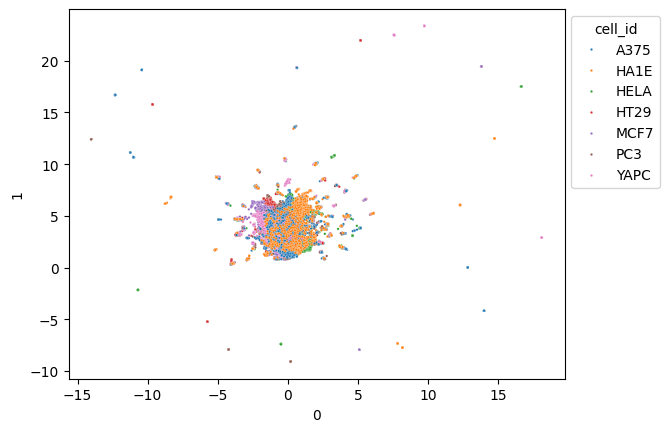

In [73]:
# cell types colored
ax = sns.scatterplot(dat, x=0, y=1, hue="cell_id", s=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

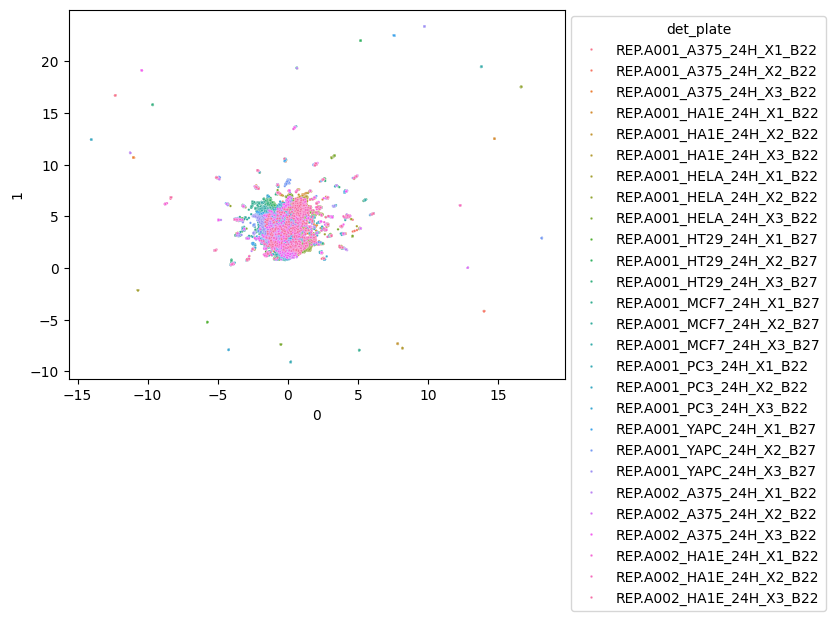

In [74]:
ax = sns.scatterplot(dat, x=0, y=1, hue="det_plate", s=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

The mixing is imperfect, but nevertheless the data points are far better mixed than before embedding and batch correction.

### Apply embeddings to target deconvolution
We will try and use these embeddings to identify
(or in this case verify) potential targets
(or disrupted pathways) for everolimus, an inhibitor of
MTOR.

We can work with the hypothesis, that a drug inhibiting
a protein target will induce a similar phenotype to a
genetic knock out of said protein target. Whether this
phenotype is measured by phenomics, transcriptomics,
or any other high through put assay, if we can make
centered embeddings, we can simply find similar phenotypes
with cosine similarity and consider these candidate targets.


In [77]:
def mean_cosine_similarity(mat):
    """calculates the mean of non-self pairwise cosine similarities in mat"""
    res = cosine_similarity(mat)
    upper_triangular_mask = np.triu(np.ones(res.shape, dtype=bool), 1)
    return np.mean(res[upper_triangular_mask])

In [89]:
# confirm our compound of interest is present in data
compound = "everolimus"
ordered_inst_info.loc[ordered_inst_info.pert_iname == compound].pert_id.value_counts()

pert_id
BRD-A25736793    398
BRD-K13154216    126
BRD-K13514097      6
Name: count, dtype: int64

Before we can dive in to actually comparing things, we have some decisions to make. In particular, what cell type and what dose should we take. We'll
also have to clean up some data inconsistencies.

In [79]:
# fix, non-exact matches in cell line naming, and make set for selecting cell lines
# with available knock outs
ordered_inst_info["cell_line"] = np.array([re.sub('\..*', '', x) for x in ordered_inst_info.cell_id])
cell_lines_2_keep = set(ordered_inst_info[ordered_inst_info.pert_type == "trt_xpr"].cell_line.unique())
cell_lines_2_keep

{'A375', 'A549', 'HA1E', 'HELA', 'HT29', 'MCF7', 'PC3', 'YAPC'}

In [90]:
# select all instances of compound perturbation on potential comparable cell lines
mask = (ordered_inst_info.pert_iname == compound) & ordered_inst_info.cell_id.isin(cell_lines_2_keep)
comp_dat = bc_vae_embedding.loc[mask]
comp_meta = ordered_inst_info.loc[mask]
# equalize rounding so dosages match
comp_meta.loc[:, 'pert_dose_rounded'] = np.round(comp_meta.pert_dose, 2)

<ipython-input-90-609c9e9eda88>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_meta.loc[:, 'pert_dose_rounded'] = np.round(comp_meta.pert_dose, 2)


In [94]:
# calcute the cosine similarity between all replicates within a given
# cell line and dosage.
# the idea here, is if replicates don't correlate, then there's likely
# no consistent effect for compound <-> comparisons
# in biological terms, these might be cases where the compound is doesed
# too low to have an effect or the protein target is not expressed
flat = comp_dat.groupby([comp_meta.cell_id, comp_meta.pert_dose_rounded]).apply(
    mean_cosine_similarity)
flat = pd.DataFrame(flat).reset_index()
# reshape to cell line X dose
pivoted = pd.pivot(flat, columns='pert_dose_rounded', index='cell_id')
pivoted.head()

0                                                    \
pert_dose_rounded     0.04      0.10      0.12      0.37      1.11      3.33    
cell_id                                                                         
A375               0.190466  0.029433  0.278842  0.368486  0.299844  0.269333   
A549               0.381414       NaN  0.318607  0.271451  0.263318  0.276921   
HA1E               0.164933       NaN  0.217335  0.276556  0.227882  0.200797   
HELA               0.120391       NaN  0.072514  0.138451  0.198963  0.242689   
HT29               0.076919       NaN  0.064585  0.079004  0.102750  0.079585   

                             
pert_dose_rounded     10.00  
cell_id                      
A375               0.210655  
A549               0.307897  
HA1E               0.250359  
HELA               0.200544  
HT29               0.151457

<Axes: xlabel='None-pert_dose_rounded', ylabel='cell_id'>

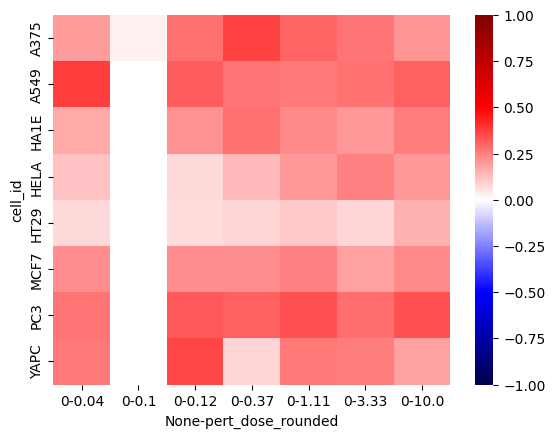

In [95]:
sns.heatmap(pivoted, vmin=-1, vmax=1, cmap="seismic")

This compound has a fairly consistent effect across cell
lines, nevertheless will focus on a couple of the strongest.

#### Find the most similar genetic knock outs


In [99]:
def query_gene_knockouts(compound, target_cell_line, min_dose, max_dose):
    cell_mask = ordered_inst_info.cell_line == target_cell_line
    genes_mask = ordered_inst_info.pert_type == "trt_xpr"

    comp_mask = ordered_inst_info.pert_iname == compound
    dose_mask = (min_dose <= ordered_inst_info.pert_dose) & (ordered_inst_info.pert_dose <=  max_dose)

    comp_dat = bc_vae_embedding.loc[cell_mask & comp_mask & dose_mask]

    sub_info = ordered_inst_info.loc[cell_mask & genes_mask]
    sub_dat = bc_vae_embedding.loc[cell_mask & genes_mask]
    g_references = sub_dat.groupby(sub_info.pert_iname).mean()
    comp_query = comp_dat.mean()
    ready = pd.concat([g_references, pd.DataFrame(comp_query).T])
    return pd.Series(cosine_similarity(ready)[-1], index=ready.index)

In [102]:
# top hits
query_gene_knockouts(compound, "A549", min_dose=0, max_dose=2).sort_values(ascending=False)[1:11]  # 0th index is always the compound

MTOR      0.484750
AURKB     0.454339
KRAS      0.447317
RPS6      0.403063
EGFR      0.397468
CRKL      0.349557
PIK3CA    0.329848
CIC       0.328326
DIDO1     0.308988
KEAP1     0.306320
dtype: float32

In [103]:
query_gene_knockouts(compound, "A375", min_dose=.11, max_dose=2).sort_values(ascending=False)[1:11]  # 0th index is always the compound

MTOR      0.527962
AURKB     0.484008
EXO1      0.441868
BRAF      0.413536
MAST4     0.366023
PTP4A1    0.358229
CRKL      0.351876
CAMK1     0.326513
DIDO1     0.325077
RPS6      0.321106
dtype: float32

In [104]:
query_gene_knockouts(compound, "YAPC", min_dose=0, max_dose=0.15).sort_values(ascending=False)[1:11]  # 0th index is always the compound

PIK3CA    0.247795
MTOR      0.210091
PLXNA1    0.166113
PTP4A1    0.156825
ITGA11    0.121790
AKT1      0.115446
ERG       0.096664
INSM2     0.089966
CDH1      0.089309
FASN      0.075639
dtype: float32

good to see MTOR robustly at or near the top of the list.

other consistent hits should be checked if they could be indirect effects
(e.g. in the pathway with MTOR); or whether they might be off target effects.


You made it!

If you have extra time, we'd encourage you to pick your favorite step of
this lab and try and optimize it.